In [29]:
from IPython.core.display import HTML

def visualize_results(loss_values, params, image_ref, image):
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.style.use('dark_background')
    matplotlib.rc('figure', facecolor=(1, 1, 1, 0))
    matplotlib.rc('axes', facecolor=(1, 1, 1, 0.05))

    def show_image(ax, img, title):
        ax.imshow(mi.util.convert_to_bitmap(img))
        ax.axis('off')
        ax.set_title(title)
    def show_heightmap(fig, ax, cax, values, title):
        values = mi.util.convert_to_bitmap(params["data"]).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)
        # values = params['data'].numpy()
        im = ax.imshow(values, vmax=1e-4)
        fig.colorbar(im, cax=cax)
        ax.axis('off')
        ax.set_title(title)

    fig, ax = plt.subplots(2, 3, figsize=(11, 10), 
                           gridspec_kw={'width_ratios': [0.5, 0.5, 0.02]})
    ax = ax.ravel()

    ax[0].plot(loss_values)
    ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); 
    ax[0].set_title('Convergence plot')

    show_heightmap(fig, ax[1], ax[2], params['data'], 'Final heightmap')
    show_image(ax[3], image_ref, 'Reference')
    show_image(ax[4], image,     'Caustic image')
    ax[5].axis('off')
    fig.tight_layout()
    plt.show()

# HTML('<style>' + open('present.css', 'r').read() + '</style>')

# Caustics optimization

![Caustic design setup diagram](figures/setup-diagram.png)

In this tutorial:

* Differentiable rendering with automatic differentiation
* Building a Mitsuba scene dynamically from Python
* Optimizing "latent" variables
* Coarse-to-fine optimization

**Full notebook**: [mitsuba.readthedocs.io/en/stable/src/inverse_rendering/caustics_optimization.html](https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/caustics_optimization.html)

## 0. Setup

In [2]:
import os
from os.path import realpath, join

import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')
mi.set_log_level(mi.LogLevel.Warn)

In [3]:
config = {
    'render_resolution': (128, 128),
    'heightmap_resolution': (512, 512),
    'n_upsampling_steps': 4,
    'spp': 32,
    'max_iterations': 1000,
    'learning_rate': 3e-5,
    'reference': 'references/sunday-128.exr',
}
output_dir = realpath(join('outputs', 'sunday-single'))
os.makedirs(output_dir, exist_ok=True)

## 1. Loading the reference image

In [4]:
image_ref = mi.TensorXf(mi.Bitmap(config['reference']))
print('[i] Reference image selected:', config['reference'])
mi.Bitmap(image_ref)

[i] Reference image selected: references/sunday-128.exr


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

## 2. Creating the scene

<br>
<br>
<br>
<br>
<br>
<br>
<br>

![Caustic design scene preview](figures/scene-preview.png)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Creating the lens mesh

<br>

![Lens mesh preview](figures/lens-heightmap.png)

<br>
→ see the full notebook for details on generating this mesh on-the-fly.

### Creating the emitter

In [5]:
bayer = dr.zeros(mi.TensorXf, (32, 32, 3))
bayer[ ::2,  ::2, 2] = 2.2
bayer[ ::2, 1::2, 1] = 2.2
bayer[1::2, 1::2, 0] = 2.2

emitter = {
    'type':'directionalarea',
    'radiance': {
        'type': 'bitmap',
        'bitmap': mi.Bitmap(bayer),
        'raw': True,
        'filter_type': 'nearest'
    },
}
mi.Bitmap(bayer)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [32, 32],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

### Creating the integrator

In [6]:
integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,
    'max_depth': 4,
    'hide_emitters': False,
}

### Assembling the scene

Mitsuba XML format:

```xml
<scene version="3.0.1">
    <sensor type="perspective">
        <!-- ... -->
    </sensor>
    <!-- ... -->
</scene>
```

In [7]:
# Looking at the receiving plane, not looking through the lens
sensor_to_world = mi.ScalarTransform4f.look_at(
    target=[0, -20, 0],
    origin=[0, -4.65, 0],
    up=[0, 0, 1]
)
resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

In [8]:
scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
    'receiving-plane': {
        'type': 'obj',
        'id': 'receiving-plane',
        'filename': 'meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f.look_at(
                target=[0, 1, 0],
                origin=[0, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
    # Glass slab, excluding the 'exit' face (added separately below)
    'slab': {
        'type': 'obj',
        'id': 'slab',
        'filename': 'meshes/slab.obj',
        'to_world': mi.ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },
    # Glass rectangle, to be optimized
    'lens': {
        'type': 'ply',
        'id': 'lens',
        'filename': join(output_dir, 'lens_{}_{}.ply'.format(*config['heightmap_resolution'])),
        'to_world': mi.ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },

    # Directional area emitter placed behind the glass slab
    'focused-emitter-shape': {
        'type': 'obj',
        'filename': 'meshes/rectangle.obj',
        'to_world': mi.ScalarTransform4f.look_at(
            target=[0, 0, 0],
            origin=[0, 5, 0],
            up=[0, 0, 1]
        ),
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
        'focused-emitter': emitter,
    },
}

In [9]:
scene = mi.load_dict(scene)
print(f'[i] Scene loaded ({len(scene.shapes())} meshes)')

[i] Scene loaded (4 meshes)


## 3. Creating the displacement texture

In [10]:
initial_heightmap_resolution = [r // (2 ** config['n_upsampling_steps']) 
                                for r in config['heightmap_resolution']]
upsampling_steps = dr.sqr(dr.linspace(mi.Float, 0, 1, config['n_upsampling_steps']+1, endpoint=False).numpy()[1:])
upsampling_steps = (config['max_iterations'] * upsampling_steps).astype(int)

In [11]:
initial_texture = mi.Bitmap(dr.zeros(mi.TensorXf, initial_heightmap_resolution))
heightmap_texture = mi.load_dict({
    'type': 'bitmap',
    'id': 'heightmap_texture',
    'bitmap': initial_texture,
    'raw': True,
})
initial_texture

Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [32, 32],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 4 KiB of image data ]
]

In [12]:
# Actually optimized: the heightmap texture
params = mi.traverse(heightmap_texture)
params.keep(['data'])
print(params)

# Create optimizer
opt = mi.ad.Adam(lr=config['learning_rate'], params=params)

SceneParameters[
  -----------------------------------------------------------
  Name    Flags    Type            Parent
  -----------------------------------------------------------
  data    ∂        TensorXf        BitmapTexture
]


## 4. Applying the displacement

In [13]:
params_scene = mi.traverse(scene)

# We will always apply displacements along the original normals and
# starting from the original positions.
positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])

lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])

In [14]:
def apply_displacement():
    # Enforce reasonable range. For reference, the receiving plane
    # is 7 scene units away from the lens.
    vmax = 1 / 100.
    params['data'] = dr.clamp(params['data'], -vmax, vmax)
    dr.enable_grad(params['data'])

    height_values = heightmap_texture.eval_1(lens_si)
    new_positions = height_values * normals_initial + positions_initial
    params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
    params_scene.update()

## 5. Running the optimization

In [15]:
import time
iterations = config['max_iterations']
loss_values = []
spp = config['spp']

def log_progress(t0, loss):
    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')

In [16]:
def scale_independent_loss(image, ref):
    """Brightness-independent L2 loss function."""
    scaled_image = image / dr.mean(dr.detach(image))
    scaled_ref = ref / dr.mean(ref)
    return dr.mean(dr.sqr(scaled_image - scaled_ref))

In [17]:
for it in range(iterations):
    t0 = time.time()
    # Apply displacement and update the scene BHV accordingly
    apply_displacement()

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=2 * spp, spp_grad=spp)

    # Scale-independent L2 function
    loss = scale_independent_loss(image, image_ref)
    # Back-propagate and take a gradient descent step
    dr.backward(loss)
    opt.step()
    
    # Increase resolution of the heightmap
    if it in upsampling_steps:
        opt['data'] = dr.upsample(opt['data'], scale_factor=(2, 2, 1))
    # Carry over the update to our "latent variable" (the heightmap values)
    params.update(opt)
    log_progress(t0, loss)
    
    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(opt.lr['data'] / 2)

Widget Javascript not detected.  It may not be installed or enabled properly.


## 6. Visualizing the results

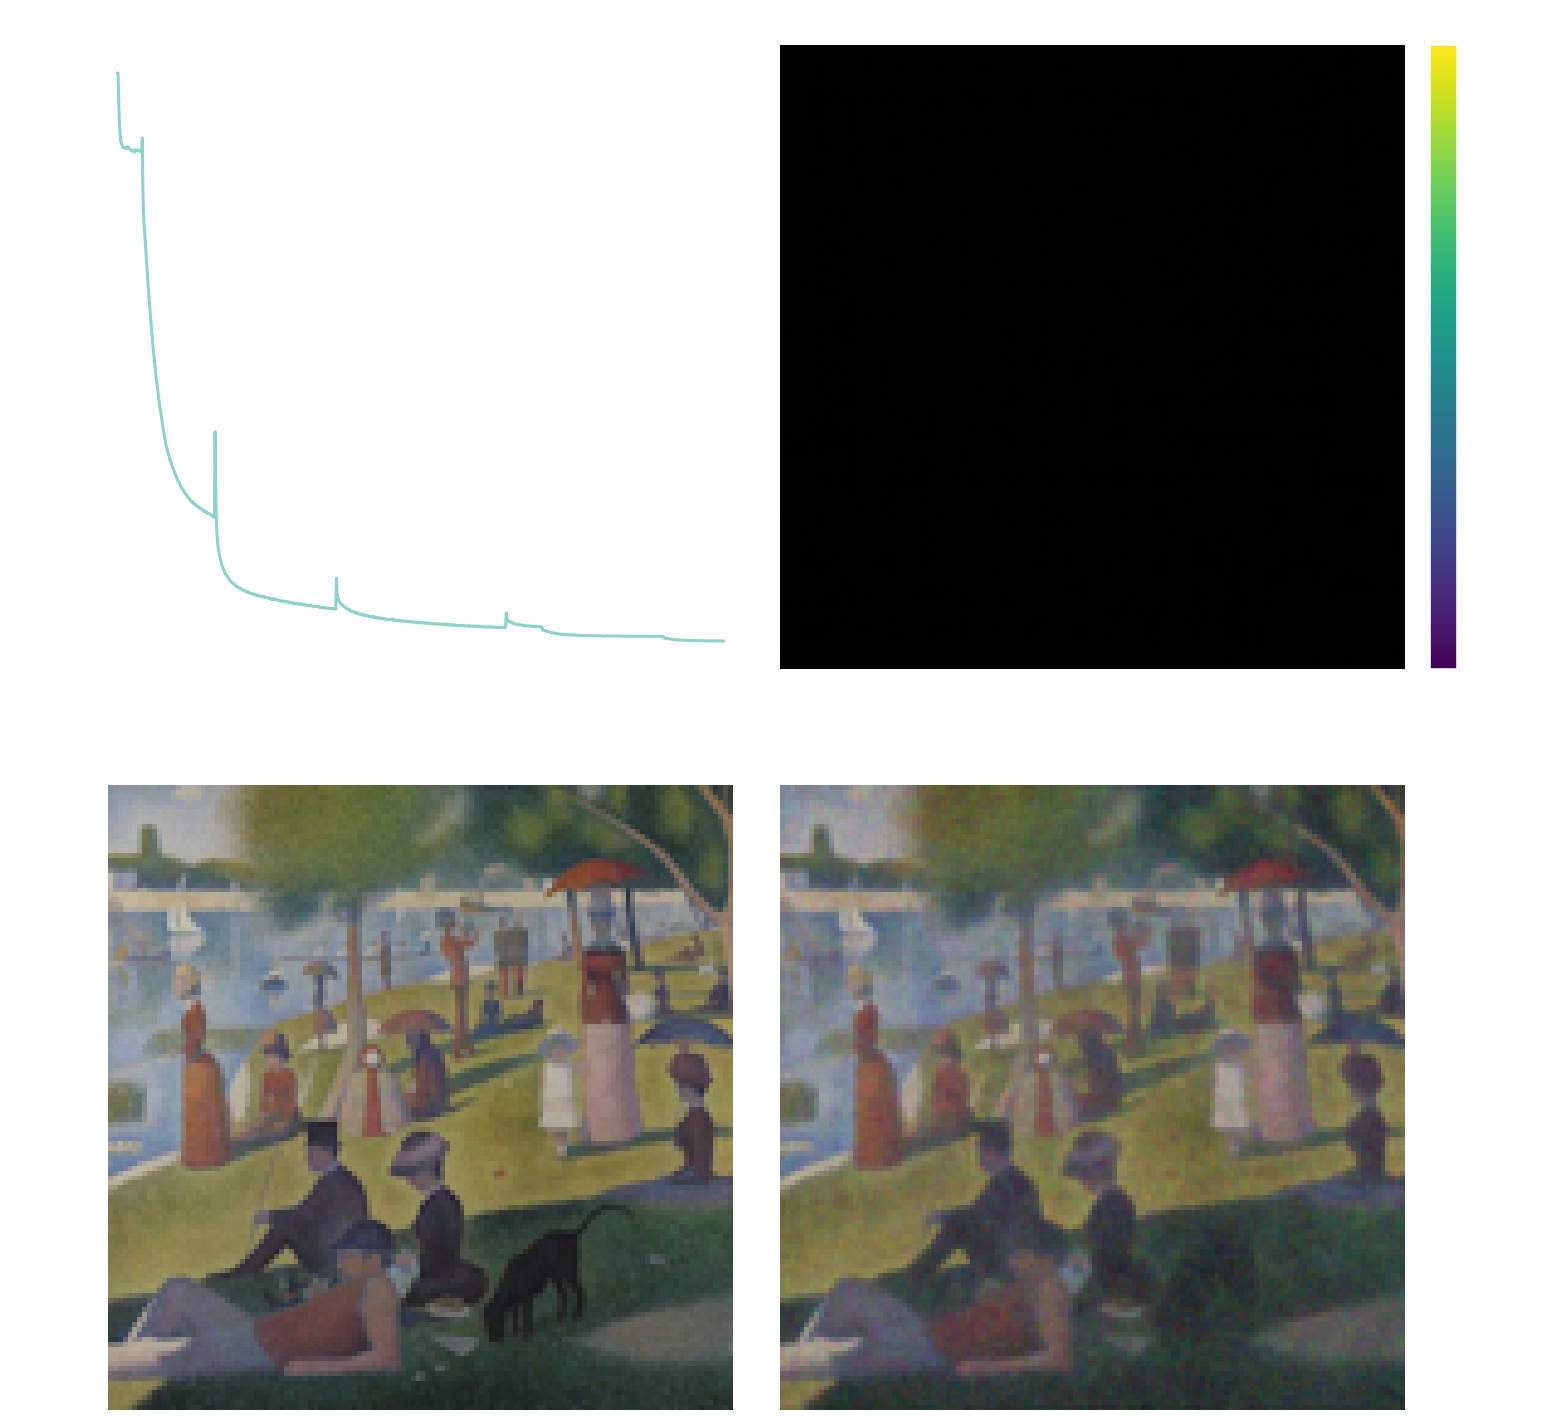

In [31]:
# See full notebook for visualization code
visualize_results(loss_values, params, image_ref, image)

<div style="height: 2500px"></div>

In [ ]:

#     # Save intermediate state
#     if (it % 2) == 0:
#         fname = f'opt_{it//2:06d}.exr'
#         mi.Bitmap(image).write(join(output_dir, fname))

### Re-rendering animation

In [ ]:
params = mi.traverse(scene)

params['sensor.x_fov'] = 75
params['sensor.film.size'] = (720, 720) #(256, 256)
params.update();

In [ ]:
import numpy as np
offsets = np.linspace(4.90, 0, 60)
targets = ['lens', 'slab']
quantities = [(mi.Point3f, 'vertex_positions'),]
init_vals = {
    target: [
        dr.unravel(tp, params[f'{target}.{q}'])
        for tp, q in quantities
    ]
    for target in targets
}

for i, offset in enumerate(offsets):
    trafo = mi.Transform4f.translate((0, offset, 0))
    
    for target in targets:
        for (_, q), v in zip(quantities, init_vals[target]):
            translated = trafo.transform_affine(v)
            params[f'{target}.{q}'] = dr.ravel(translated)
    params.update()
    #print(dr.mean_nested(params['lens.vertex_positions']))
    
    img = mi.render(scene, spp=512)
    fname = join(output_dir, f'translate_{i:06d}.exr')
    mi.Bitmap(img).write(fname)
    
# Restore initial values
for target in targets:
    for (_, q), v in zip(quantities, init_vals[target]):
        params[f'{target}.{q}'] = dr.ravel(v)
params.update();

2022-11-01 11:32:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2022-11-01 11:32:24 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2022-11-01 11:32:34 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

KeyboardInterrupt: 

### Illustrating the displaced mesh

In [ ]:
import numpy as np
import matplotlib

lens_res = (16, 16)
m = create_flat_lens_mesh(lens_res)

lens_fname = join(output_dir, 'lens_{}_{}.ply'.format(*lens_res))
m.write_ply(lens_fname)
print(f'[+] Wrote lens mesh ({lens_res[0]}x{lens_res[1]} tesselation)')
del m

mesh = mi.load_dict({
    'type': 'ply',
    'filename': lens_fname,
})
mesh_params = mi.traverse(mesh)

rng = np.random.default_rng(seed=1234)
heightmap = rng.uniform(size=(16, 16))
heightmap[:, 0] = 0
heightmap[0, :] = 0
heightmap[:, -1] = 0
heightmap[-1, :] = 0
perturb = (
    0.05 * mi.Float(heightmap.ravel()) 
    * dr.unravel(mi.Normal3f, mesh_params['vertex_normals'])
)
mesh_params['vertex_positions'] += dr.ravel(perturb)  #  - dr.mean_nested(perturb)
mesh_params.update()

lens_fname2 = join(output_dir, 'lens_{}_{}_noise.ply'.format(*lens_res))
mesh.write_ply(lens_fname2)
print(f'[+] Wrote perturbed lens mesh ({lens_res[0]}x{lens_res[1]} tesselation)')

In [ ]:
import skimage.transform

cm = matplotlib.cm.get_cmap('OrRd')
img = cm(matplotlib.colors.Normalize()(heightmap))
#img = np.repeat(img, (2, 2, 1))
img = skimage.transform.resize(img, (512, 512, 4), order=0)
b = mi.Bitmap(img.astype(np.float32))
b.convert(component_format=mi.Struct.Type.UInt8)\
 .write(join(output_dir, 'heightfield_example.png'))

print(f'[+] Wrote heightmap')

### Creating the lens mesh

In [ ]:
def generate_lens_buffers(resolution):
    # Generate UV coordinates
    U, V = dr.meshgrid(
        dr.linspace(mi.Float, 0, 1, resolution[0]),
        dr.linspace(mi.Float, 0, 1, resolution[1]),
        indexing='ij'
    )
    texcoords = mi.Vector2f(U, V)
    
    # Generate vertex coordinates
    X = 2.0 * (U - 0.5)
    Y = 2.0 * (V - 0.5)
    vertices = mi.Vector3f(X, Y, 0.0)

    # Create two triangles per grid cell
    faces_x, faces_y, faces_z = [], [], []
    for i in range(resolution[0] - 1):
        for j in range(resolution[1] - 1):
            v00 = i * resolution[1] + j
            v01 = v00 + 1
            v10 = (i + 1) * resolution[1] + j
            v11 = v10 + 1
            faces_x.extend([v00, v01])
            faces_y.extend([v10, v10])
            faces_z.extend([v01, v11])
    faces = mi.Vector3u(faces_x, faces_y, faces_z)
    
    return vertices, faces, texcoords

In [ ]:
def create_flat_lens_mesh(resolution):
    vertices, faces, texcoords = generate_lens_buffers(resolution)

    # Instantiate the mesh object
    mesh = mi.Mesh("lens-mesh", resolution[0] * resolution[1], dr.width(faces), 
                   has_vertex_texcoords=True)
    
    # Set its buffers
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(vertices)
    mesh_params['vertex_texcoords'] = dr.ravel(texcoords)
    mesh_params['faces'] = dr.ravel(faces)
    mesh_params.update()

    return mesh

In [ ]:
lens_res = config['heightmap_resolution']
m = create_flat_lens_mesh(lens_res)

lens_fname = join(output_dir, 'lens_{}_{}.ply'.format(*lens_res))
m.write_ply(lens_fname)
print(f'[+] Wrote lens mesh ({lens_res[0]}x{lens_res[1]} tesselation)')

In [ ]:
# Save final results
fname = join(output_dir, 'heightmap_final.exr')
mi.util.write_bitmap(fname, params['data'])
print('[+] Saved final heightmap state to:', fname)

fname = join(output_dir, 'lens_displaced.ply')
apply_displacement()
lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
lens_mesh.write_ply(fname)
print('[+] Saved displaced lens to:', fname)